# What the fuck

In [3]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt

from osgeo import ogr
import pyvista as pv
import os
import sys
from scipy.spatial import KDTree

from interessant import * # Bei Änderungen Kernel neu starten
sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.centralpoints import *
from algs.voxelfilter import *

from scipy.spatial.transform import Rotation as R

ogr.UseExceptions()

In [4]:
run = "/media/riannek/minimax/gleis/run24-2024-08-13"


# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45; 47 Drei

key = list(interessant.keys())[0] 

filename = interessant[key]

print(key, filename)

plyfilename = filename.split(".")[0] + ".ply"
filename = os.path.join(run, filename)


if not os.path.exists(filename):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.copc.laz


In [5]:
gauge = 1.435
railhead_width = 0.067

tile_size = 25          # side length of each file
voxelcount = 30 

voxel_empty_space_thresh = 10 # 10 good for low noise data
voxel_top_percentile = 99.5   # 99.5 good for low noise data, with noise try 98

voxel_majority_thresh = 0.5
voxel_minimum_points = 50
voxel_ground_percentile = 10

neighborhood_radius = 0.5
linearity_tresh = 0.98 
thresh_side_distance = 0.15 # Must be > 0.15 for tight curves

cluster_minimum_points = 10 
seedpoint_distance = 0.3 

intensity_threshold=14500

In [6]:
def get_seedpoints(points):
    low_intensity = points[points["Intensity"] < 14500]
    downsampling_pipeline = pdal.Filter("filters.sample", radius=s.seedpoint_distance).pipeline(low_intensity)
    downsampling_pipeline.execute()
    seed_points = downsampling_pipeline.arrays[0]
    return np.vstack((seed_points["X"], seed_points["Y"], seed_points["Z"])).T


def read_pointcloud(filename):
    pipeline = pdal.Pipeline([pdal.Reader(filename)])
    pipeline.execute()
    points = pipeline.arrays[0]
    xyz = np.vstack((points["X"], points["Y"], points["Z"])).T
    return xyz, points

def get_points(xyz, xyz_seed): 
    points = []
    tree = KDTree(xyz)
    # indices: ndarray (dtype object) with a list of indices for each seed point
    indices = tree.query_ball_point(xyz_seed, r=s.neighborhood_radius, workers=-1)

    seed_point_count = len(xyz_seed)

    for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator(xyz, tree, indices, seed_point_count, gauge):
        transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
        representive_a, side_a  = representive_point(cluster, transformmatrix, railhead_width) 
        representive_b, side_b = representive_point(cluster_other, transformmatrix, railhead_width)

        if representive_a is None or representive_b is None:
            # Happens in rare cases at switches
            continue

        # Check if both are classified as the same side
        # but a zero and non zero value is not a problem
        if side_a * side_b < 0:
            # Update the cluster with lower confidence of the side estimation
            if np.abs(side_a) < np.abs(side_b):
                representive_a, side_a  = representive_point(cluster, transformmatrix, railhead_width, side=side_b)
            else:
                representive_b, side_b = representive_point(cluster_other, transformmatrix,  railhead_width, side=side_a)

        if representive_a is None or representive_b is None:
            continue

        central = get_central_point(representive_a, representive_b)

        points.append(central)
        points.append(representive_a)
        points.append(representive_b)

    return np.array(points)

In [7]:
run24_tmp = "/media/riannek/minimax/gleis/temp_run24"
ply_run24 = os.path.join(run24_tmp, "candidates", plyfilename)
xyz_ply_run24, points_ply_run24 = read_pointcloud(ply_run24)
seed24 = get_seedpoints(points_ply_run24)

offset = xyz_ply_run24.mean(axis=0)
xyz_ply_run24 -= offset
seed24 -= offset

plypoints24 = get_points(xyz_ply_run24, seed24)



In [8]:
voxel_size = tile_size / voxelcount

constraints = GeometryConstraints(
    voxel_size, 
    voxel_minimum_points, 
    voxel_empty_space_thresh, 
    voxel_ground_percentile, 
    voxel_top_percentile,
    voxel_majority_thresh, 
    )

points, _ = voxelfilter(
    filename, 
    voxel_size,
    constraints,
    cluster_minimum_points,
    "",
    write=False,
    )

if points is None:
    raise ValueError("No rail points found in the file.")

In [9]:
low_intensity = points[points["Intensity"] < intensity_threshold]
downsampling_pipeline = pdal.Filter("filters.sample", radius=seedpoint_distance).pipeline(low_intensity)
downsampling_pipeline.execute()


seed_points = downsampling_pipeline.arrays[0]
seed_point_count = len(seed_points)

# Center the data, KD Tree
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()
# offset = xyz.mean(axis=0)
xyz -= offset
xyz_seed -= offset

tree = KDTree(xyz)
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)


In [10]:
def plot_cluster_pair_compare(cluster, cluster_other, transformmatrix, representive_a, representive_b, representive_aa, representive_bb, railhead_width = 0.067): 
    """Compare both versions of represantive points 
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix

    representive_aa = representive_aa - center_cluster
    representive_bb = representive_bb - center_other
    representive_aa = representive_aa @ transformmatrix
    representive_bb = representive_bb @ transformmatrix




    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        representive_aa, representive_bb = representive_bb, representive_aa
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    ax[0].set_ylim(-0.08, 0.08)
    ax[1].set_ylim(-0.08, 0.08)

    ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")


    ax[0].axvline(representive_a[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(representive_a[2], color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    ax[1].axvline(representive_b[0], color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(representive_b[2], color="forestgreen", linestyle="--", zorder=-1)

    ax[0].axvline(representive_aa[0], color="steelblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aa[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_aa[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axhline(representive_aa[2], color="steelblue", linestyle="--", zorder=-1)


    ax[1].axvline(representive_bb[0], color="steelblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bb[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_bb[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axhline(representive_bb[2], color="steelblue", linestyle="--", zorder=-1)



    plt.show()
    return fig, ax, transformed, transformed_other

In [11]:
def representive_point_3(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None):
    """Version 3

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])
    return transformed_representive @ transformmatrix.T + center, side

In [41]:

def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects, verbose=False):
    """Get a 3x3 transformation matrix to transform clusters to a local coordinate system
    
    In the local coordinate system, the x axis is parallel to the line connecting 
    the rail top on both sides, the y axis is in the direction of the rail. 
    The z axis is perpendicular and points up.

    :param cluster: Cluster of points
    :type cluster: numpy.ndarray
    :param cluster_other: Other cluster of points on the other rail
    :type cluster_other: numpy.ndarray
    :param clustercenter: Center of the cluster
    :type clustercenter: numpy.ndarray
    :param clustercenter_other: Center of the other cluster
    :type clustercenter_other: numpy.ndarray
    :param eigenvects: Eigenvectors of the cluster
    :type eigenvects: numpy.ndarray
    :returns: Transformation matrix
    :rtype: numpy.ndarray
    """
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    if normal[2] < 0:
        if verbose:
            print("Normal vector points down, rotate 180° around x axis")
        # vector points down, rotate 180° around x axis
        Rx_180 = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0, -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 

    return matrix

In [13]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [14]:
centralpoints = []
railtoppoints = []
clustercenters = []
clustermax = []

for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator(xyz, tree, indices, seed_point_count, gauge):
        transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
        representive_a, side_a  = representive_point(cluster, transformmatrix, railhead_width) 
        representive_b, side_b = representive_point(cluster_other, transformmatrix, railhead_width)

        if representive_a is None or representive_b is None:
            # Happens in rare cases at switches
            continue

        # Check if both are classified as the same side
        # but a zero and non zero value is not a problem
        if side_a * side_b < 0:
            # Update the cluster with lower confidence of the side estimation
            if np.abs(side_a) < np.abs(side_b):
                representive_a, side_a  = representive_point(cluster, transformmatrix, railhead_width, side=side_b)
            else:
                representive_b, side_b = representive_point(cluster_other, transformmatrix,  railhead_width, side=side_a)

        if representive_a is None or representive_b is None:
            continue

        central = get_central_point(representive_a, representive_b)
        railtoppoints.append(representive_a)
        railtoppoints.append(representive_b)
        centralpoints.append(central)
        clustercenters.append(clustercenter)
        clustercenters.append(center_other)
        clustermax.append(cluster[:,2].max(axis=0))
        clustermax.append(cluster_other[:,2].max(axis=0))

In [15]:
railtoppoints = np.array(railtoppoints)
centralpoints = np.array(centralpoints)
clustercenters = np.array(clustercenters)
clustermax = np.array(clustermax)

In [123]:
pcl_all = pv.PolyData(xyz)
pcentral = pv.PolyData(centralpoints)
ptop = pv.PolyData(railtoppoints)

pclc = pv.PolyData(clustercenters)

p = pv.Plotter()
p.add_mesh(pcl_all, color="grey", opacity=0.5, point_size=2)
#p.add_mesh(pclc, color="blue", point_size=3)

p.add_mesh(pcentral, color="red",  point_size=5)
p.add_mesh(ptop, color="red",  point_size=5)

p.show()

Widget(value='<iframe src="http://localhost:33565/index.html?ui=P_0x7f2bb4a299a0_1&reconnect=auto" class="pyvi…

In [121]:
pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.5, 0.5, 0.5])
pcd_rep = o3d.geometry.PointCloud()
pcd_rep.points = o3d.utility.Vector3dVector(railtoppoints)
pcd_rep.paint_uniform_color([1, 0, 0])

pcd_ply = o3d.geometry.PointCloud()
pcd_ply.points = o3d.utility.Vector3dVector(plypoints24)
pcd_ply.paint_uniform_color([0, 0, 1])

o3d.visualization.draw_geometries([pcd_all,  pcd_ply])

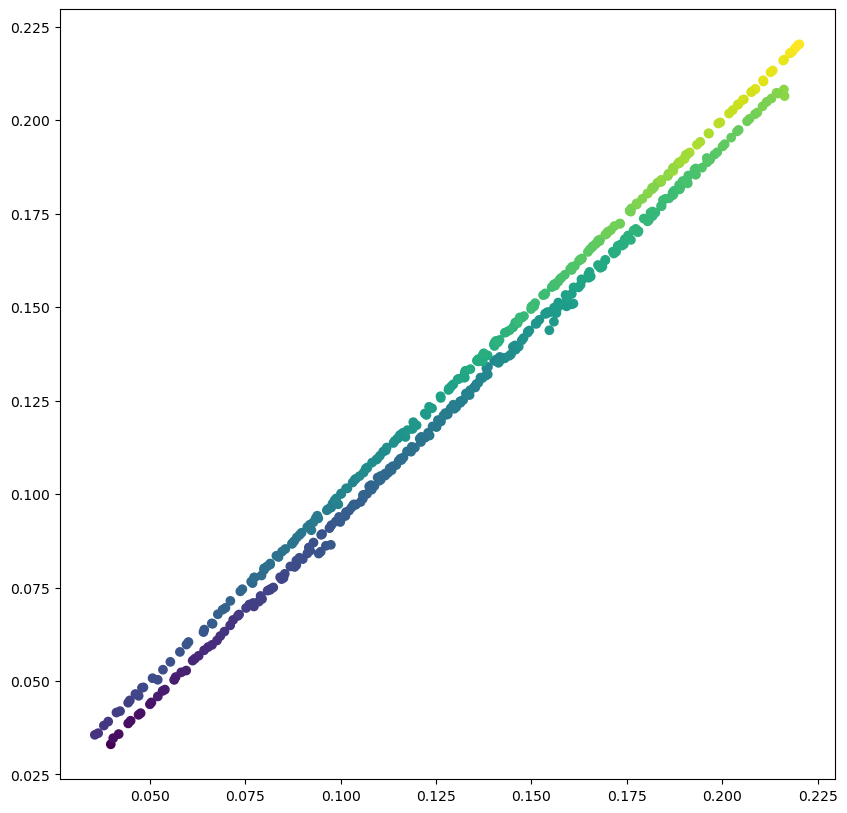

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(railtoppoints[:,2], clustercenters[:,2], c=clustermax)

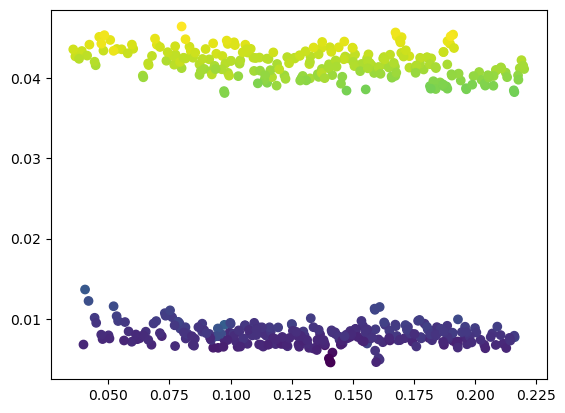

In [19]:
delta = clustermax - railtoppoints[:,2] 
c = clustermax - clustercenters[:,2]
plt.scatter(railtoppoints[:,2], delta, c=c)

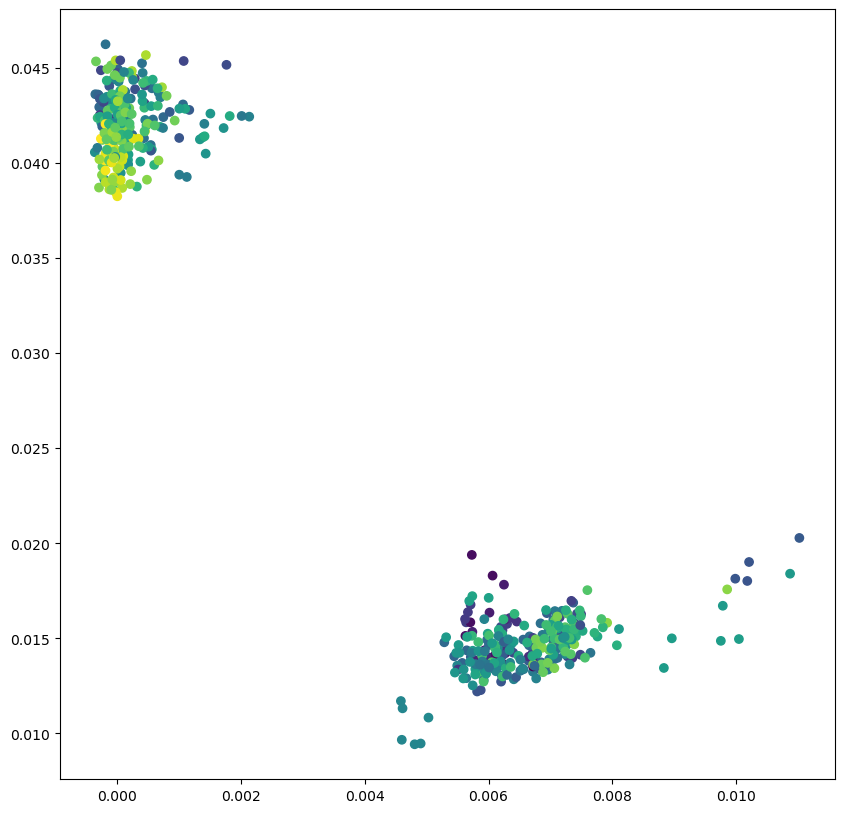

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(railtoppoints[:,2] - clustercenters[:,2], clustermax- clustercenters[:,2], c=clustermax)

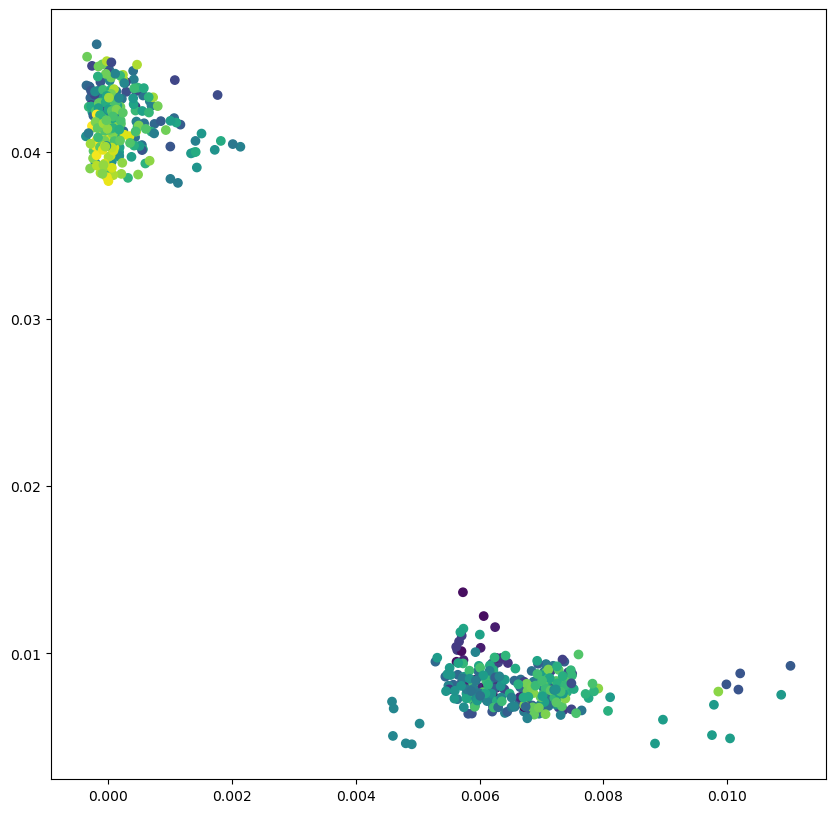

In [21]:
plt.figure(figsize=(10, 10))
plt.scatter(railtoppoints[:,2] - clustercenters[:,2], clustermax- railtoppoints[:,2], c=clustermax)

# Einzeln

In [22]:
pair_gen = pair_generator(xyz, tree, indices, seed_point_count, gauge)

In [92]:
for i in range(30):
    next(pair_gen)

Normal vector points down, rotate 180° around x axis
Points per Cluster 443 481
Switched clusters


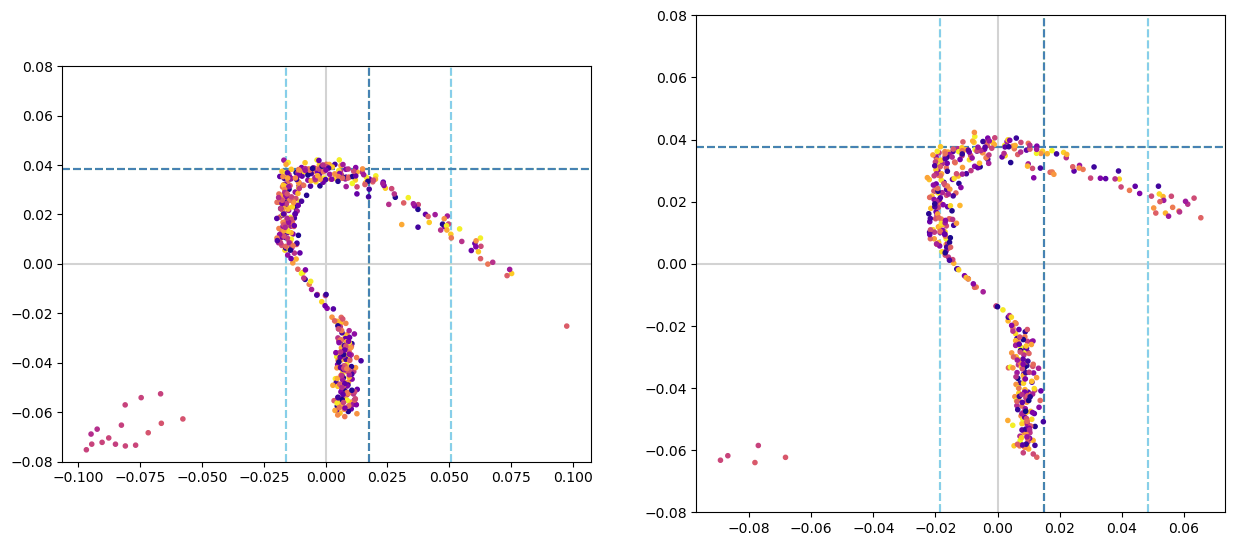

In [111]:
cluster, clustercenter, cluster_other, clustercenter_other, eigenvects = next(pair_gen)

percentile = 95

upperpercentile=90
lowerpercentile = 70

transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects, verbose=True)
#print("Transformmatrix")
#print(transformmatrix)

if transformmatrix[2,2] < 0: # z of the third eigenvector
    print("Inverted eigenvectors")
    transformmatrix *= -1
    
representive_a, side_a = representive_point(cluster, transformmatrix)
representive_b, side_b = representive_point(cluster_other, transformmatrix)

if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representive_a, side_a  = representive_point(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_b)
    else:
        representive_b, side_b = representive_point(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_a)

representative_aa, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)
representative_bb, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067)

if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_aa, side_a  = representive_point_3(cluster, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_b)
    else:
        representative_bb, side_b = representive_point_3(cluster_other, transformmatrix, upperpercentile=upperpercentile, lowerpercentile=lowerpercentile, railhead_width=0.067, side=side_a)


    #representative_aaa, representative_bbb = representative_bbb, representative_aaa


#o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representive])
print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair_compare(cluster, cluster_other, transformmatrix, representive_a, representive_b, representative_aa, representative_bb,  railhead_width = 0.067)





In [115]:
representive_a, representative_aa 

(array([-4.50912017,  4.10829034,  0.1744873 ]),
 array([-4.50912017,  4.10829034,  0.1744873 ]))

In [122]:
bla = np.vstack((representive_a, cluster.mean(axis=0)))
axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1, origin=cluster.mean(axis=0))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cluster)
pcd.paint_uniform_color([0.5, 0.5, 0.5])

rep = o3d.geometry.PointCloud()
rep.points = o3d.utility.Vector3dVector(bla)
rep.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([pcd, rep, axes])

In [116]:
# cluster_other
bla = np.vstack((representive_b, cluster_other.mean(axis=0)))
axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1, origin=cluster_other.mean(axis=0))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(cluster_other)
pcd.paint_uniform_color([0.5, 0.5, 0.5])

rep = o3d.geometry.PointCloud()
rep.points = o3d.utility.Vector3dVector(bla)
rep.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([pcd, rep, axes])

In [94]:
r = R.from_matrix(transformmatrix)
r.as_euler('xyz', degrees=True)

array([  -0.47998182,    1.25682037, -173.37483312])

In [95]:
rotvec = r.as_rotvec()
rotvec

array([ 0.03245288,  0.01459435, -3.02566854])

In [96]:
rotvec / np.linalg.norm(rotvec) , np.linalg.norm(rotvec) * 180 / np.pi # Achse, Winkel

(array([ 0.01072511,  0.00482318, -0.99993085]),
 np.float64(173.37002597515735))

In [97]:
# transformed_representive @ transformmatrix.T + center, side
transformed, rcenter, side = representive_point_bla(cluster, transformmatrix)

In [98]:
transformed 

array([0.01487059, 0.        , 0.03762613])

In [99]:
(transformed @ transformmatrix.T) #+ rcenter

array([-0.01555111, -0.00212357,  0.03728959])

In [100]:
rcenter 

array([-4.49356906,  4.11041391,  0.13719771])

In [101]:
representive_a 

array([-4.50912017,  4.10829034,  0.1744873 ])

In [102]:
cluster.mean(axis=0)

array([-4.49356906,  4.11041391,  0.13719771])

In [103]:
cluster.max(axis=0)[2] 

np.float64(0.18100335086933228)

In [104]:
cluster.max(axis=0)[2]  - cluster.mean(axis=0)[2]

np.float64(0.043805643340892875)

In [105]:
representive_a - cluster.mean(axis=0)

array([-0.01555111, -0.00212357,  0.03728959])

In [106]:
cluster.max(axis=0)[2] - representive_a[2] 

np.float64(0.006516052198689171)

In [109]:
np.linalg.det(transformmatrix)

np.float64(0.9999999999999994)

In [110]:
transformmatrix @ transformmatrix.T

array([[1.00000000e+00, 5.63886330e-17, 9.17846209e-18],
       [5.63886330e-17, 1.00000000e+00, 1.73324074e-18],
       [9.17846209e-18, 1.73324074e-18, 1.00000000e+00]])